In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 98.7 MB/s eta 0:00:00


In [ ]:
# Load the earthquake dataset
file_path = "USGS_query.csv"  # Update this path if needed
df_eq = pd.read_csv(file_path)

In [ ]:
# Define the GMPE function (Boore-Atkinson 2008 for shallow crustal earthquakes)
import math
e = math.e

def compute_pga(magnitude, distance_km):
    """
    Compute Peak Ground Acceleration (PGA) using a simplified Boore-Atkinson GMPE.
    Assumes a fixed distance.
    """

    # Coefficients from Boore-Atkinson (2008)
    c1, c2, c3 = -0.66050, 0.11970, -0.01151
    e1, e5, e6 = -0.53804, 0.28805, -0.10164
    U = 1  # assume unspecified (U) fault type
    Mh = 6.75  # set Mh in range of 6.5-7
    Mref = 4.5  # coefficient in predicative analysis
    h = 1.35  # coefficient in predicative analysis
    Rref = 1  # coefficient in predicative analysis
    #R = (distance_km**2 + h**2)**0.5  # distance function
    R = max(math.sqrt(distance_km**2 + h**2), 1.0)  # Avoid log(0) or negative values


    Fm = e1*U + e5*(magnitude - Mh) + e6*((magnitude - Mh)**2)  # magnitude scaling
    Fd = ((c1 + c2*(magnitude - Mref)) * math.log(R / Rref)) + (c3*(R - Rref))  # distance function
    Fs = 3.7  # site amplification (soil amplification) in ground motion
    epsilon = -1.5  #  fractional number of standard deviations of a single predicted value of pga
    o =  0.502  # intra-event aleatory uncertainty
    T =  0.265  # inter-event aleatory uncertainty
    oT = (o**2 + T**2)**0.5  # coefficient representing combined uncertainty

    pga = math.exp(min(max(Fm + Fd + Fs + epsilon * oT, -10), 10))  # Prevent extreme values
    return max(pga, 0.0001)  # Prevent negative values

# Assume a fixed site distance of 50 km for analysis
df_eq["pga"] = df_eq.apply(lambda row: compute_pga(row["mag"], 50), axis=1)

# Convert PGA to MMI using an empirical equation - Atkinson & Kaka (2007)
df_eq["mmi"] = 3.10 * np.log10(df_eq["pga"]) + 3.92

# Select relevant columns for display
df_processed = df_eq[["time", "latitude", "longitude", "depth", "mag", "place", "pga", "mmi"]]

# Save processed data to a new CSV file
df_processed.to_csv("Processed_Earthquake_Data.csv", index=False)

In [ ]:
# Display the processed data
print(df_processed.head())
print(max(df_eq["mmi"]))

                       time   latitude   longitude  depth   mag  \
0  2025-01-26T14:03:01.190Z  40.334833 -124.942833   7.04  4.13   
1  2025-01-02T02:34:04.660Z  38.845500 -122.756333   1.42  4.65   
2  2024-12-17T01:08:14.980Z  40.282000 -123.710667  28.97  4.05   
3  2024-12-10T13:01:07.270Z  40.332500 -124.792000   5.82  4.17   
4  2024-12-10T00:39:56.966Z  39.168600 -119.022500   8.10  4.20   

                            place       pga       mmi  
0       56 km WNW of Petrolia, CA  0.085135  0.603339  
1             4 km NW of Cobb, CA  0.161906  1.468714  
2          20 km NE of Redway, CA  0.076744  0.463636  
3       43 km WNW of Petrolia, CA  0.089625  0.672534  
4  23 km NNE of Yerington, Nevada  0.093128  0.724142  
4.550249365620851


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


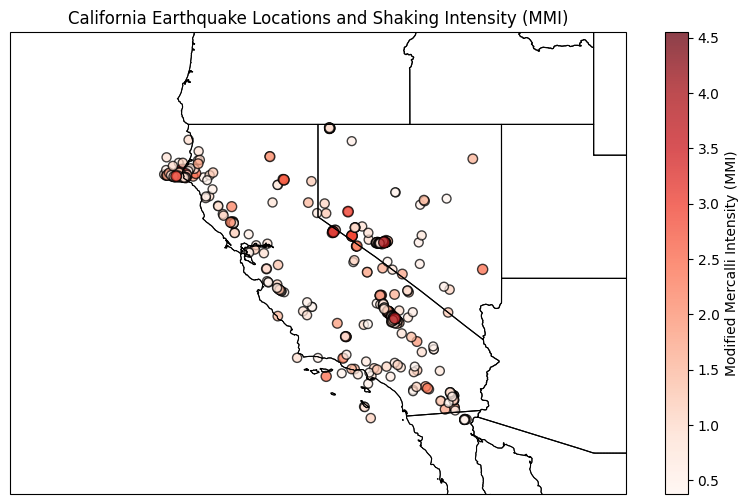

In [ ]:
# Create a figure with Cartopy's PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set map extent to California
ax.set_extent([-130, -110, 30, 45], crs=ccrs.PlateCarree())

# Add geographical features
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=":")
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor="black")  # State boundaries

# Scatter plot of earthquake locations
sc = ax.scatter(
    df_processed["longitude"], df_processed["latitude"],
    c=df_processed["mmi"], cmap="Reds", edgecolors="black",
    s=df_processed["mag"] * 10, alpha=0.75, transform=ccrs.PlateCarree()
)

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Modified Mercalli Intensity (MMI)")

# Labels and title
ax.set_title("California Earthquake Locations and Shaking Intensity (MMI)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show plot
plt.show()

<ipython-input-10-b89390f4246c>:58: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_eq["buffer"] = gdf_eq.geometry.buffer(gdf_eq["MMI_Radius_km"] / 111)


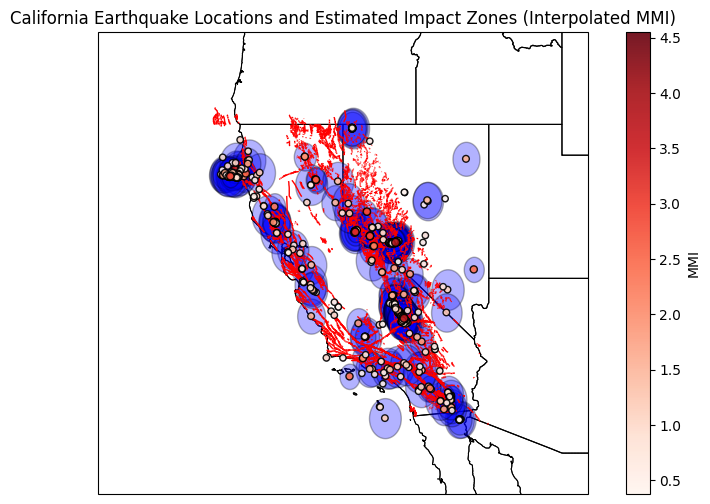

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import geopandas as gpd

# Load earthquake dataset
file_path = "USGS_query.csv"
df_eq = pd.read_csv(file_path)

# Define reasonable shaking distances (in km) for whole-number MMI levels
mmi_shaking_distances = {
    1: 75,  # Not felt
    2: 50,  # Weak
    3: 40,  # Weak to light
    4: 30,  # Light
    5: 20,  # Moderate
    6: 15,  # Strong
    7: 10,   # Very strong
    8: 5,   # Severe
    9: 4,   # Violent
    10: 3   # Extreme
}

def interpolate_mmi_radius(mmi_value):
    """
    Interpolates the shaking distance for non-integer MMI values using linear interpolation.
    """
    # Find the two closest whole-number MMI levels
    mmi_low = int(np.floor(mmi_value))
    mmi_high = int(np.ceil(mmi_value))

    # If the MMI is exactly an integer, return its predefined distance
    if mmi_low == mmi_high:
        return mmi_shaking_distances.get(mmi_low, 10)  # Default to 10 km if out of range

    # Ensure both values exist in the dictionary
    if mmi_low in mmi_shaking_distances and mmi_high in mmi_shaking_distances:
        radius_low = mmi_shaking_distances[mmi_low]
        radius_high = mmi_shaking_distances[mmi_high]
        # Linear interpolation to calculate a radius when the MMI is between two integers
        return radius_low + (radius_high - radius_low) * (mmi_value - mmi_low)

    return 10  # Default minimum radius

# Compute interpolated radii for each earthquake based on its exact MMI value
df_eq["MMI_Radius_km"] = df_processed["mmi"].apply(interpolate_mmi_radius)

# Convert earthquake DataFrame to GeoDataFrame
gdf_eq = gpd.GeoDataFrame(df_eq,
                          geometry=gpd.points_from_xy(df_eq["longitude"], df_eq["latitude"]),
                          crs="EPSG:4326")

# Convert shaking radius from km to degrees (~111 km per degree latitude)
gdf_eq["buffer"] = gdf_eq.geometry.buffer(gdf_eq["MMI_Radius_km"] / 111)

# Create a figure with Cartopy's PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set map extent to California
ax.set_extent([-130, -110, 30, 45], crs=ccrs.PlateCarree())

# Add fault lines to map
fault_lines = gpd.read_file("Cali_faults.geojson")


# Add geographical features
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=":")
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor="black")
fault_lines.plot(ax=ax, color="red", linewidth=1, transform=ccrs.PlateCarree(), label="Fault Lines")


# Plot buffers (radius around each earthquake)
for _, row in gdf_eq.iterrows():
    if row["buffer"] is not None:
        ax.add_geometries([row["buffer"]], crs=ccrs.PlateCarree(), facecolor='blue', alpha=0.3, edgecolor='black')

# Scatter plot of earthquake locations after buffers
sc = ax.scatter(df_eq["longitude"], df_eq["latitude"],
                c=df_processed["mmi"], cmap="Reds", edgecolors="black",
                s=df_eq["mag"] * 5, alpha=0.9, transform=ccrs.PlateCarree(), zorder=3)

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("MMI")

# Labels and title
ax.set_title("California Earthquake Locations and Estimated Impact Zones (Interpolated MMI)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Save plot instead of displaying
plt.savefig("earthquake_mmi_buffer_map.png", dpi=300)
plt.show()


In [ ]:
# Add parcel data
county_file = "orange_county_parcel_clean2.csv"
df_parcel = pd.read_csv(county_file)

# Normalize the improvement values for better color scaling
df_parcel["Improvement.Value"] = pd.to_numeric(df_parcel["Improvement.Value"], errors="coerce")


# Convert to GeoDataFrame (assuming columns are named 'longitude' and 'latitude')
gdf_parcel = gpd.GeoDataFrame(df_parcel,
                              geometry=gpd.points_from_xy(df_parcel["Location.Longitude"], df_parcel["Location.Latitude"]),
                              crs="EPSG:4326")

# Remove rows where Improvement Value is zero, less than 1000, or Improvement Base Year is zero
gdf_parcel = gdf_parcel[(gdf_parcel["Improvement.Value"] >= 1000) & (gdf_parcel["Improvement.Base.Year"] > 0)]

print(min(gdf_parcel['Improvement.Value']))

1196


<ipython-input-19-2827edb1d795>:46: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_eq["buffer"] = gdf_eq.geometry.buffer(gdf_eq["MMI_Radius_km"] / 111)


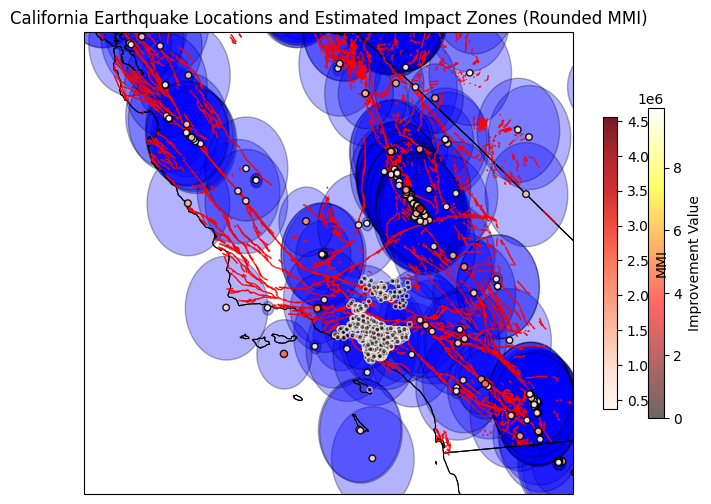

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import geopandas as gpd

# Load earthquake dataset
file_path = "Processed_Earthquake_Data.csv"
df_eq = pd.read_csv(file_path)

# Define predefined shaking distances (in km) for whole-number MMI levels
mmi_shaking_distances = {
    1: 75,  # Not felt
    2: 50,  # Weak
    3: 40,  # Weak to light
    4: 30,  # Light
    5: 20,  # Moderate
    6: 15,  # Strong
    7: 10,   # Very strong
    8: 5,   # Severe
    9: 4,   # Violent
    10: 3   # Extreme
}

def round_mmi_radius(mmi_value):
    """
    Rounds the MMI value to the nearest whole number and assigns a predefined shaking radius.
    """
    # Round MMI to the nearest whole number
    rounded_mmi = int(round(mmi_value))

    # Return the corresponding shaking radius (default to 10 km if out of range)
    return mmi_shaking_distances.get(rounded_mmi, 10)

# Compute rounded radii for each earthquake based on its MMI value
df_eq["MMI_Radius_km"] = df_eq["mmi"].apply(round_mmi_radius)

# Convert earthquake DataFrame to GeoDataFrame
gdf_eq = gpd.GeoDataFrame(df_eq,
                          geometry=gpd.points_from_xy(df_eq["longitude"], df_eq["latitude"]),
                          crs="EPSG:4326")

# Convert shaking radius from km to degrees (~111 km per degree latitude)
gdf_eq["buffer"] = gdf_eq.geometry.buffer(gdf_eq["MMI_Radius_km"] / 111)

# Create a figure with Cartopy's PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set map extent to California
ax.set_extent([-123, -115, 32, 38], crs=ccrs.PlateCarree())

# Add fault lines to map
fault_lines = gpd.read_file("Cali_faults.geojson")


# Add geographical features
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=":")
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor="black")
fault_lines.plot(ax=ax, color="red", linewidth=1, transform=ccrs.PlateCarree(), label="Fault Lines")


# Plot buffers (radius around each earthquake) first
for _, row in gdf_eq.iterrows():
    if row["buffer"] is not None:
        ax.add_geometries([row["buffer"]], crs=ccrs.PlateCarree(),
                          facecolor='blue', alpha=0.3, edgecolor='black', zorder=1)


# Scatter plot of earthquake locations after buffers
sc_eq = ax.scatter(df_eq["longitude"], df_eq["latitude"],
                c=df_eq["mmi"], cmap="Reds", edgecolors="black",
                s=df_eq["mag"] * 5, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)


# Scatter plot for Orange County parcels with improvement values as color
sc_parcels = ax.scatter(df_parcel["Location.Longitude"], df_parcel["Location.Latitude"],
                        c=df_parcel["Improvement.Value"], cmap="hot",edgecolors="white", marker="o",
                        s=13, alpha=0.6, transform=ccrs.PlateCarree(), zorder=3,
                        label="Improvement Value")


# Add parcel color bar
cbar_parcels = plt.colorbar(sc_parcels, ax=ax, fraction=0.02, pad=0.04)
cbar_parcels.set_label("Improvement Value")

# Add MMI color bar
cbar_eq = plt.colorbar(sc_eq, ax=ax, fraction=0.02, pad=0.04)
cbar_eq.set_label("MMI")


# Labels and title
ax.set_title("California Earthquake Locations and Estimated Impact Zones (Rounded MMI)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Save plot instead of displaying
#plt.savefig("earthquake_mmi_buffer_map.png", dpi=300)
plt.show()

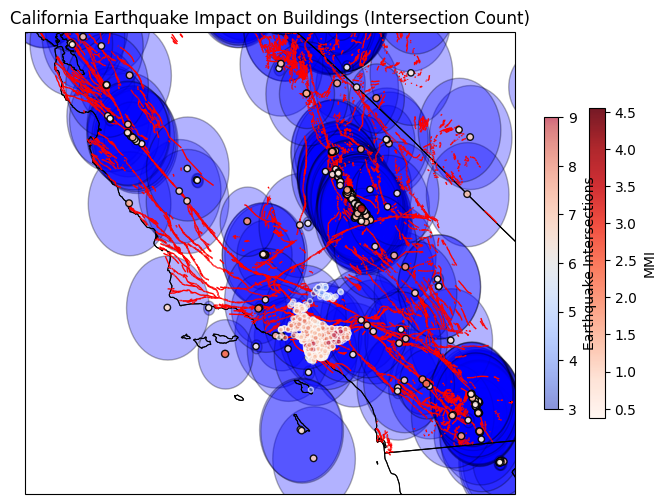

In [ ]:
### Assign a score to each building based on felt MMI

# Count intersections: How many times a parcel falls inside an earthquake buffer
def count_intersections(point):
    return sum(point.intersects(buffer) for buffer in gdf_eq["buffer"])

gdf_parcel["Earthquake_Intersections"] = gdf_parcel.geometry.apply(count_intersections)

# Save the results
gdf_parcel.to_csv("parcel_with_earthquake_scores.csv", index=False)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-130, -110, 30, 45], crs=ccrs.PlateCarree())

# Load fault lines
#fault_lines = gpd.read_file("Cali_faults.geojson")

# Add geographical features
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=":")
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor="black")
#fault_lines.plot(ax=ax, color="red", linewidth=1, transform=ccrs.PlateCarree(), label="Fault Lines")

# Plot buffers
for _, row in gdf_eq.iterrows():
    if row["buffer"] is not None:
        ax.add_geometries([row["buffer"]], crs=ccrs.PlateCarree(),
                          facecolor='blue', alpha=0.3, edgecolor='black', zorder=1)

# Scatter plot of earthquakes
sc_eq = ax.scatter(df_eq["longitude"], df_eq["latitude"],
                   c=df_eq["mmi"], cmap="Reds", edgecolors="black",
                   s=df_eq["mag"] * 5, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)

# Scatter plot for parcels with color-coded intersection scores
sc_parcels = ax.scatter(gdf_parcel["Location.Longitude"], gdf_parcel["Location.Latitude"],
                        c=gdf_parcel["Earthquake_Intersections"], cmap="coolwarm",
                        edgecolors="white", marker="o", s=13, alpha=0.6,
                        transform=ccrs.PlateCarree(), zorder=3)

# Add color bars
cbar_eq = plt.colorbar(sc_eq, ax=ax, fraction=0.02, pad=0.04)
cbar_eq.set_label("MMI")


cbar_parcels = plt.colorbar(sc_parcels, ax=ax, fraction=0.02, pad=0.04)
cbar_parcels.set_label("Earthquake Intersections")


# Labels and title
ax.set_title("California Earthquake Impact on Buildings (Intersection Count)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [ ]:
## Assign a score based on base improvement year. A high score indicates high vulnerability

# Define a function to calculate the base year score
def calc_year_score(year):
    if year < 1975:
        return 10  # Extremely vulnerable (oldest buildings in dataset)
    elif 1975 <= year < 1980:
        return 9  # Highly vulnerable
    elif 1980 <= year < 1985:
        return 8  # Very vulnerable
    elif 1985 <= year < 1990:
        return 7  # Moderately vulnerable
    elif 1990 <= year < 1995:
        return 6  # Somewhat vulnerable
    elif 1995 <= year < 2000:
        return 5  # Slightly vulnerable
    elif 2000 <= year < 2005:
        return 4  # Low vulnerability
    elif 2005 <= year < 2010:
        return 3  # Very low vulnerability
    elif 2010 <= year < 2015:
        return 2  # Minimal vulnerability
    else:
        return 1  # Least vulnerable (most recent constructions)

# Apply the function to assign base year scores
gdf_parcel['Base_year_score'] = gdf_parcel['Improvement.Base.Year'].apply(calc_year_score)

In [ ]:
# Define a function to calculate the vulnerability score based on Improvement Value
def calc_value_score(value):
    if value < 25000:
        return 10  # Extremely vulnerable (very low-value buildings)
    elif 25000 <= value < 50000:
        return 9  # Highly vulnerable
    elif 50000 <= value < 100000:
        return 8  # Very vulnerable
    elif 100000 <= value < 150000:
        return 7  # Moderately vulnerable
    elif 150000 <= value < 200000:
        return 6  # Somewhat vulnerable
    elif 200000 <= value < 300000:
        return 5  # Slightly vulnerable
    elif 300000 <= value < 400000:
        return 4  # Low vulnerability
    elif 400000 <= value < 500000:
        return 3  # Very low vulnerability
    elif 500000 <= value < 750000:
        return 2  # Minimal vulnerability
    else:
        return 1  # Least vulnerable (high-value buildings)

# Apply the function to assign improvement value scores
gdf_parcel['Improvement_Value_Score'] = gdf_parcel['Improvement.Value'].apply(calc_value_score)


In [ ]:
## Assign a score based on location on faults

# Count intersections: How many times a parcel falls on a fault line
def count_intersections(point):
    return sum(point.intersects(faults) for faults in fault_lines['geometry'])

gdf_parcel["Fault_Intersections"] = gdf_parcel.geometry.apply(count_intersections)


KeyboardInterrupt: 

In [ ]:
# Define structural risk score
gdf_parcel['Structure_risk_score'] = gdf_parcel['Improvement_Value_Score'] + gdf_parcel['Base_year_score']


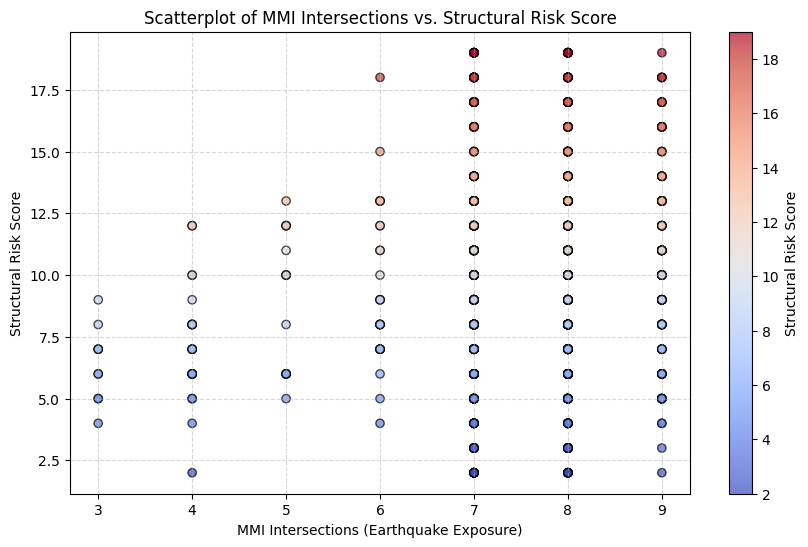

In [ ]:
# Plot all buildings as a function of structural damage risk (fragility) and MMI

# Create scatter plot with MMI intersections on the x-axis and Structural Risk Score on the y-axis
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(
    gdf_parcel["Earthquake_Intersections"],
    gdf_parcel["Structure_risk_score"],
    c=gdf_parcel["Structure_risk_score"],
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="black"
)

# Labels and title
plt.xlabel("MMI Intersections (Earthquake Exposure)")
plt.ylabel("Structural Risk Score")
plt.title("Scatterplot of MMI Intersections vs. Structural Risk Score")
plt.colorbar(label="Structural Risk Score")
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()


Normal Equation solution:
  Intercept: 6.083
  Slope:     0.486


<ipython-input-15-f126d690617e>:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X = X.ravel()
<ipython-input-15-f126d690617e>:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()


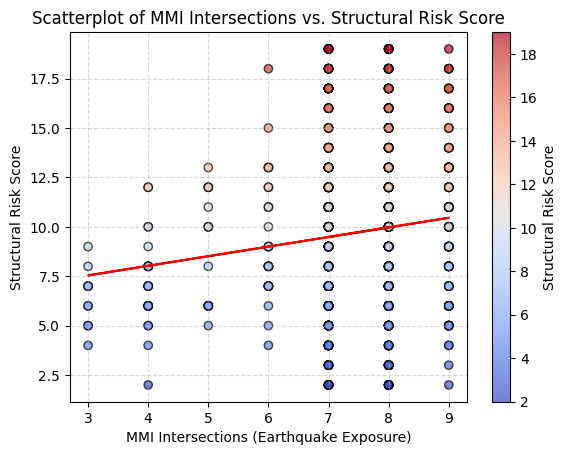

In [ ]:
# Perform a linear regression using normal equation

# Define parameters
X = gdf_parcel["Earthquake_Intersections"]
X = X.ravel()
y = gdf_parcel["Structure_risk_score"]
y = y.ravel()
N = 906


# @title Normal Equation
# 1) Reshape X back to (N, 1) to build the design matrix
X_reshaped = X.reshape(-1, 1)

# 2) Add a column of ones for the intercept term
X_b = np.c_[np.ones((N, 1)), X_reshaped]  # shape: (N,2)
#   X_b[:,0] = 1, X_b[:,1] = X

# 3) Normal Equation: theta = (X^T X)^(-1) X^T y
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
intercept_ne, slope_ne = theta_best[0], theta_best[1]
y_pred_ne = X_b.dot(theta_best)

print("Normal Equation solution:")
print(f"  Intercept: {intercept_ne:.3f}")
print(f"  Slope:     {slope_ne:.3f}")

# 4) Visualize the fitted line

plt.scatter(
    gdf_parcel["Earthquake_Intersections"],
    gdf_parcel["Structure_risk_score"],
    c=gdf_parcel["Structure_risk_score"],
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="black"
)

plt.xlabel("MMI Intersections (Earthquake Exposure)")
plt.ylabel("Structural Risk Score")
plt.title("Scatterplot of MMI Intersections vs. Structural Risk Score")
plt.colorbar(label="Structural Risk Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.plot(X, y_pred_ne, 'r-', label="Fitted line (Normal Eq)")


Scikit-Learn solution:
  Intercept: 6.082707132214809
  Slope:     0.48589225561961513


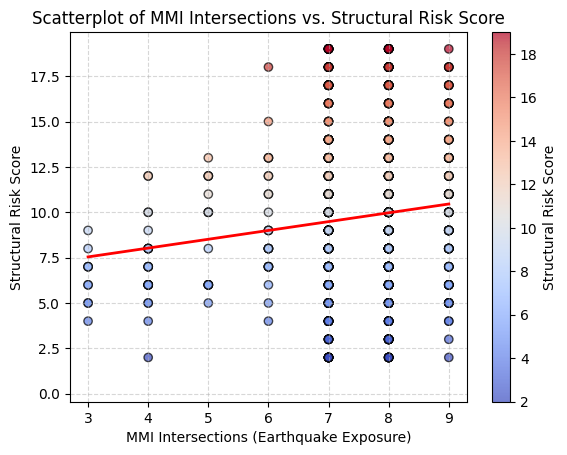

In [ ]:
# @title Scikit-Learn
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit the linear regression model
X_reshaped_sklearn = X.reshape(-1, 1)
lin_reg = LinearRegression()
lin_reg.fit(X_reshaped_sklearn, y)

# Generate predictions for the regression line
X_range = np.linspace(min(X), max(X), 100).reshape(-1, 1)
y_pred = lin_reg.predict(X_range)

print("Scikit-Learn solution:")
print(f"  Intercept: {lin_reg.intercept_}")
print(f"  Slope:     {lin_reg.coef_[0]}")

slope = lin_reg.coef_[0]
y_int = lin_reg.intercept_


plt.scatter(
    gdf_parcel["Earthquake_Intersections"],
    gdf_parcel["Structure_risk_score"],
    c=gdf_parcel["Structure_risk_score"],
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="black"
)

plt.xlabel("MMI Intersections (Earthquake Exposure)")
plt.ylabel("Structural Risk Score")
plt.title("Scatterplot of MMI Intersections vs. Structural Risk Score")
plt.colorbar(label="Structural Risk Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.plot(X_range, y_pred, color="red", linewidth=2, label=f"Regression Line (y = {lin_reg.coef_[0]:.2f}x + {lin_reg.intercept_:.2f})")
plt.plot(y_int, slope, 'r-', label="Fitted line")


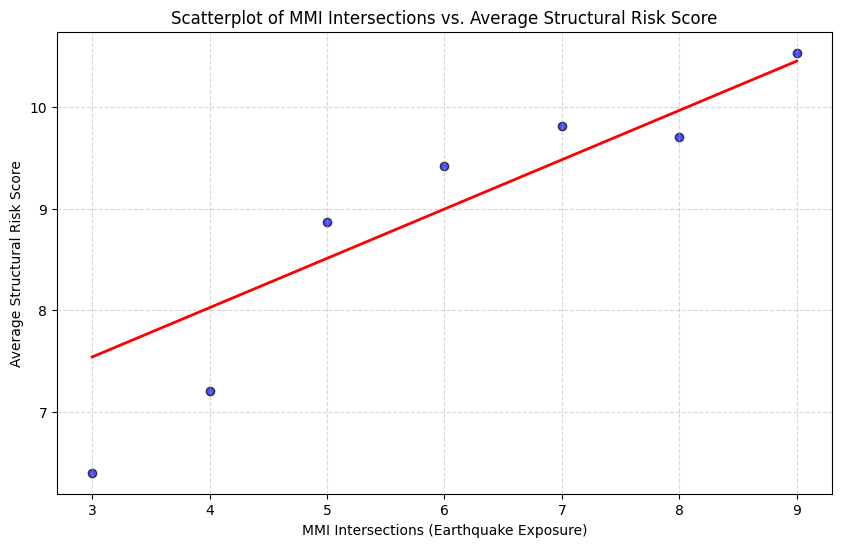

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average structural risk score for each level of earthquake exposure (MMI intersections)
avg_risk_per_mmi = gdf_parcel.groupby("Earthquake_Intersections")["Structure_risk_score"].mean().reset_index()

# Create scatter plot with MMI intersections on the x-axis and average structural risk score on the y-axis
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(
    avg_risk_per_mmi["Earthquake_Intersections"],
    avg_risk_per_mmi["Structure_risk_score"],
    color="blue",
    alpha=0.7,
    edgecolors="black"
)

# Labels and title
plt.xlabel("MMI Intersections (Earthquake Exposure)")
plt.ylabel("Average Structural Risk Score")
plt.title("Scatterplot of MMI Intersections vs. Average Structural Risk Score")
plt.grid(True, linestyle="--", alpha=0.5)

plt.plot(X_range, y_pred, color="red", linewidth=2, label=f"Regression Line (y = {lin_reg.coef_[0]:.2f}x + {lin_reg.intercept_:.2f})")

# Show plot
plt.show()




Mean Squared Error on Train Data: 0.0 




Mean Squared Error on Test Data: 0.3628766510448032 




<ipython-input-18-165f2ac6ff48>:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X = X.ravel()
<ipython-input-18-165f2ac6ff48>:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()


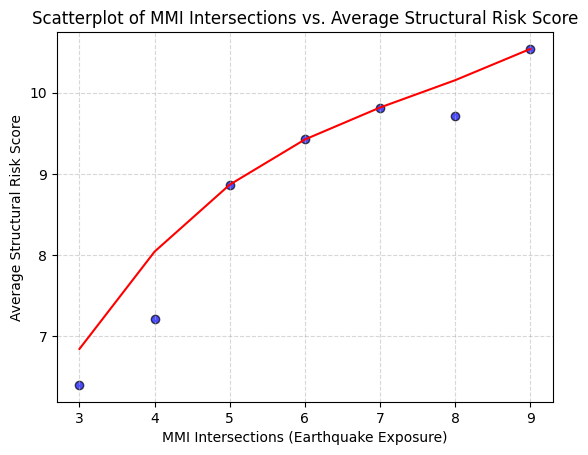

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Define data
X = avg_risk_per_mmi["Earthquake_Intersections"]
X = X.ravel()
X = X.reshape(-1, 1)
y = avg_risk_per_mmi["Structure_risk_score"]
y = y.ravel()


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#Define degree of polynomial regression
degree = 3

# Set up polynomial regression model
polynomial_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), LinearRegression())

# Fit the model to training data
polynomial_model.fit(X_train, y_train)

# Predict on test data
predictions = polynomial_model.predict(X_test)

# Compute Mean Squared Error (for training data)
mse_train = mean_squared_error(y_train, polynomial_model.predict(X_train))
print("\n\nMean Squared Error on Train Data:", mse_train, "\n\n")


# Compute Mean Squared Error (for test data)
mse = mean_squared_error(y_test, predictions)
print("\n\nMean Squared Error on Test Data:", mse, "\n\n")


# Predictions for plotting
X_line = X
y_line = polynomial_model.predict(X)



# Scatter plot
plt.scatter(
    avg_risk_per_mmi["Earthquake_Intersections"],
    avg_risk_per_mmi["Structure_risk_score"],
    color="blue",
    alpha=0.7,
    edgecolors="black"
)

# Labels and title
plt.xlabel("MMI Intersections (Earthquake Exposure)")
plt.ylabel("Average Structural Risk Score")
plt.title("Scatterplot of MMI Intersections vs. Average Structural Risk Score")
plt.grid(True, linestyle="--", alpha=0.5)

plt.plot(X, y_line, color="red", label=f"Polynomial Regression (degree={degree})")



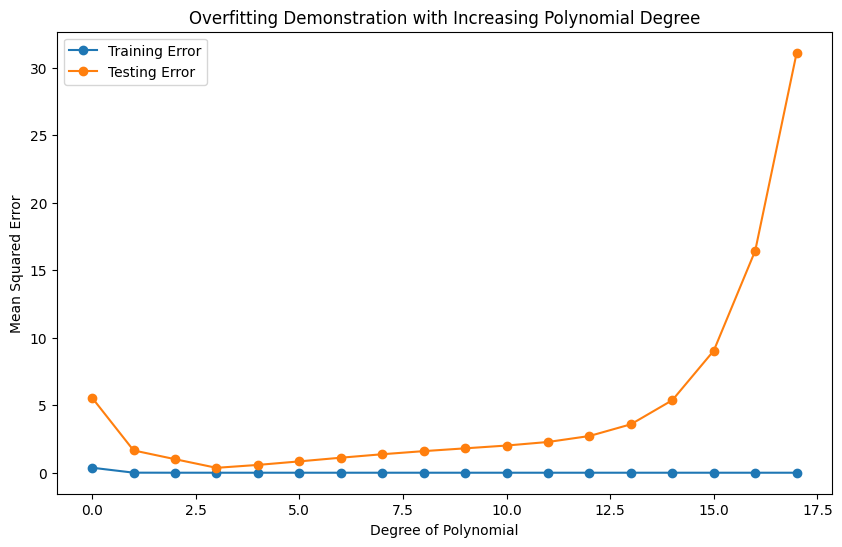



Mean Squared Error on Train Data: [0.3704439248994077, 0.0039016193646772062, 0.000405611152801565, 1.2345673166708835e-26, 4.993489530049005e-28, 1.9169319996870587e-28, 4.9698237028923744e-29, 1.1044052673094165e-29, 2.68212707775144e-29, 1.6424084046701466e-27, 1.5169795207400057e-27, 4.275626106297884e-28, 2.4548483623482144e-24, 4.0349446441149533e-25, 1.9244340668957105e-25, 1.7624257027904713e-25, 2.7573844081095247e-26, 1.5544504137380038e-25] 




Mean Squared Error on Test Data: [5.551593145498397, 1.6521134051496362, 1.0030900993474214, 0.3628766510450408, 0.5778034355490368, 0.8401649102534791, 1.1122787026003456, 1.3690842546606719, 1.599348750092749, 1.806557084843302, 2.013825996316411, 2.2779125390537565, 2.720095566892916, 3.588027843875494, 5.37483227356854, 9.044095003916015, 16.450096423119753, 31.116342687515353] 




In [ ]:
# Initialize lists to store errors
train_errors = []
test_errors = []
degrees = range(0, 18)  # Try polynomial degrees from 0 to 18

# Iterate over polynomial degrees
for degree in degrees:
    # Set up polynomial regression model with the current degree
    polynomial_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    # Fit the model to the training data
    polynomial_model.fit(X_train, y_train)

    # Predict on training and testing data
    y_train_pred = polynomial_model.predict(X_train)
    y_test_pred = polynomial_model.predict(X_test)

    # Compute Mean Squared Errors for training and testing sets
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))


# Visualize training and testing errors for each degree
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label="Training Error", marker="o")
plt.plot(degrees, test_errors, label="Testing Error", marker="o")
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Squared Error")
plt.title("Overfitting Demonstration with Increasing Polynomial Degree")
plt.legend()
plt.show()

print("\n\nMean Squared Error on Train Data:", train_errors, "\n\n")
print("\n\nMean Squared Error on Test Data:", test_errors, "\n\n")

In [ ]:
## Normalize base year and value to 0-1 range

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Initialize separate scalers
scaler_base_year = MinMaxScaler()
scaler_improvement_value = MinMaxScaler()

# Log transform the Improvement Value to reduce skewness
gdf_parcel["Log_Improvement_Value"] = np.log1p(gdf_parcel["Improvement.Value"])

# Normalize Improvement Base Year
gdf_parcel["Normalized_Base_Year"] = scaler_base_year.fit_transform(gdf_parcel[["Improvement.Base.Year"]])

# Normalize the log-transformed Improvement Value
gdf_parcel["Normalized_Improvement_Value"] = scaler_improvement_value.fit_transform(gdf_parcel[["Log_Improvement_Value"]])

csv_file_path = "gdf_parcel.csv"
gdf_parcel.to_csv(csv_file_path, index=False)

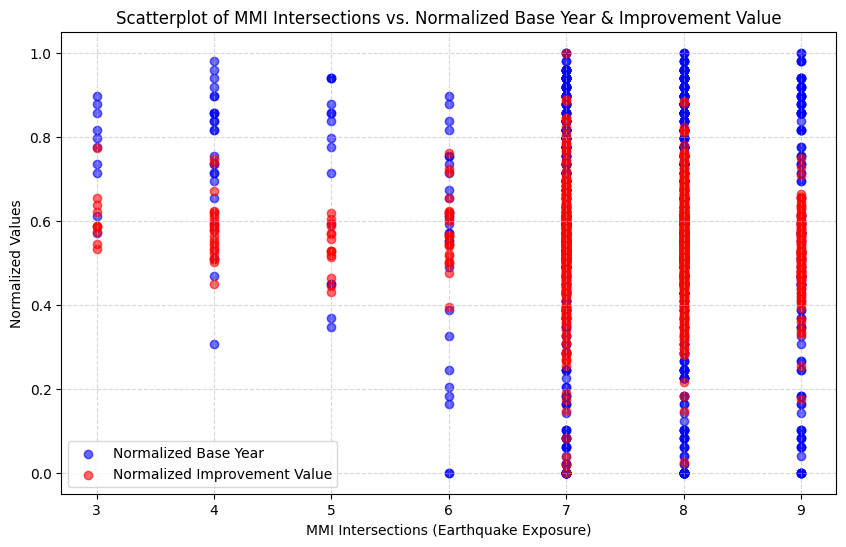

In [ ]:
# Plot all buildings as a function of year built, improvement value, and MMI

# Create scatter plot with MMI intersections on the x-axis and normalized values on the y-axis
plt.figure(figsize=(10, 6))

# Plot Normalized Base Year
plt.scatter(
    gdf_parcel["Earthquake_Intersections"],
    gdf_parcel["Normalized_Base_Year"],
    color="blue", label="Normalized Base Year", alpha=0.6
)

# Plot Normalized Improvement Value
plt.scatter(
    gdf_parcel["Earthquake_Intersections"],
    gdf_parcel["Normalized_Improvement_Value"],
    color="red", label="Normalized Improvement Value", alpha=0.6
)

# Labels and title
plt.xlabel("MMI Intersections (Earthquake Exposure)")
plt.ylabel("Normalized Values")
plt.title("Scatterplot of MMI Intersections vs. Normalized Base Year & Improvement Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()


In [ ]:
# Calculate the average normalized base year and value for each level of earthquake exposure (MMI intersections)
avg_year_per_mmi = gdf_parcel.groupby("Earthquake_Intersections")["Normalized_Base_Year"].mean().reset_index()
avg_value_per_mmi = gdf_parcel.groupby("Earthquake_Intersections")["Normalized_Improvement_Value"].mean().reset_index()


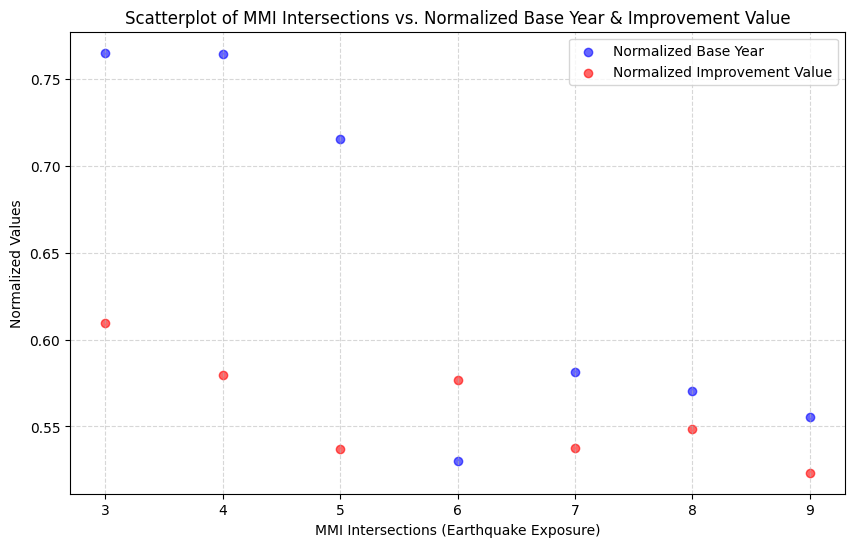

In [ ]:
# Calculate the average structural risk score for each level of earthquake exposure (MMI intersections)
avg_year_per_mmi = gdf_parcel.groupby("Earthquake_Intersections")["Normalized_Base_Year"].mean().reset_index()

avg_value_per_mmi = gdf_parcel.groupby("Earthquake_Intersections")["Normalized_Improvement_Value"].mean().reset_index()


# Create scatter plot with MMI intersections on the x-axis and normalized values on the y-axis
plt.figure(figsize=(10, 6))

# Plot Normalized Base Year
plt.scatter(
    avg_year_per_mmi["Earthquake_Intersections"],
    avg_year_per_mmi["Normalized_Base_Year"],
    color="blue", label="Normalized Base Year", alpha=0.6
)

# Plot Normalized Improvement Value
plt.scatter(
    avg_value_per_mmi["Earthquake_Intersections"],
    avg_value_per_mmi["Normalized_Improvement_Value"],
    color="red", label="Normalized Improvement Value", alpha=0.6
)

# Labels and title
plt.xlabel("MMI Intersections (Earthquake Exposure)")
plt.ylabel("Normalized Values")
plt.title("Scatterplot of MMI Intersections vs. Normalized Base Year & Improvement Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()
